# Enhanced Road Sign Detection

## Dataset 
For this project, we will be using the German Traffic Sign Dataset (GTSDB) (https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/published-archive.html). 

This dataset consists of 900 full images (1360 x 800 pixels) in PPM format. We will be training and testing the SVM model using the provided training set (600 full images) and testing set (300 full images) from the above link (training set is from TrainIJCNN2013.zip and testing set is from TestIJCNN2013.zip). In our working directory, the training set is in folder 'train' and the testing set is in folder 'test'.

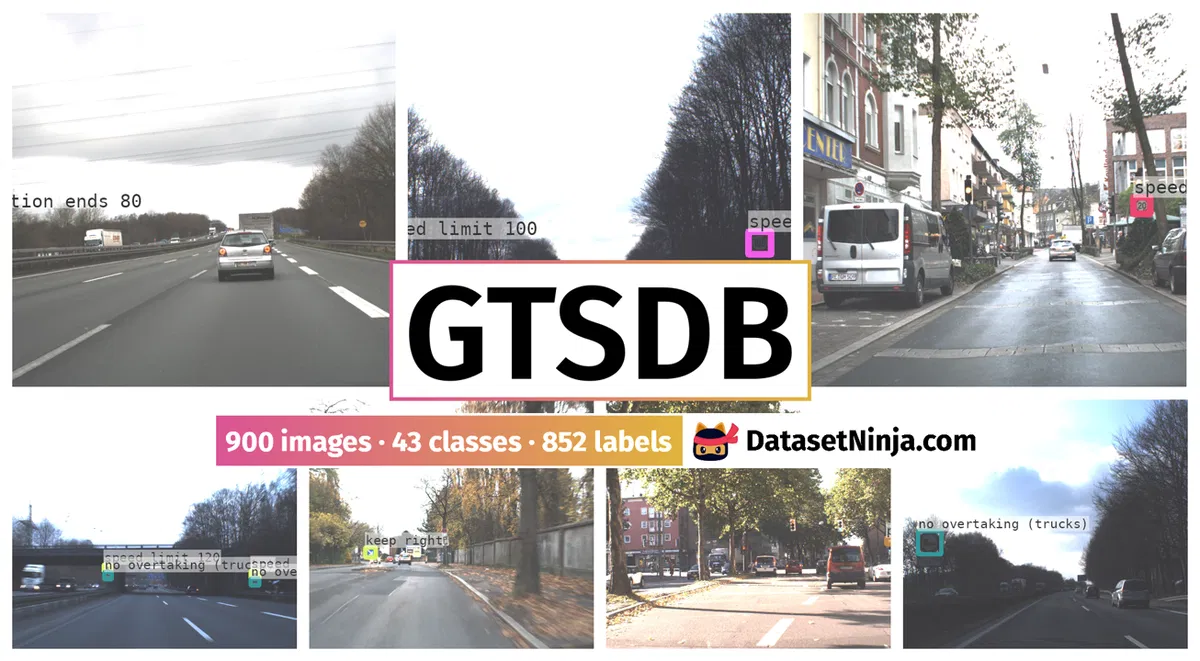

## Working Directory Layout
Our working directory should look as follows:

```plaintext
GTSDB_Project
|
|__ train/
|
|__ test/
|
|__ GTSDB_detection.ipynb
|
|__ requirements.txt

In [1]:
import os
import re
import cv2
import random
random.seed(42)
import pickle
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 43
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

In [3]:
def parse_labels(file_path):
    labels = {}
    pattern = re.compile(r'(\d+)\s*=\s*(.*?)\s*(\([^)]*\))?$')  # Match "n = description (type)"
    with open(file_path, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                label = int(match.group(1))
                description = match.group(2).strip()
                labels[label] = description

    return labels 

label_annotation_file = os.path.join(TRAIN_DIR, 'ReadMe.txt')
LABELS = parse_labels(label_annotation_file)
LABELS[43] = 'traffic lights'

for label, description in LABELS.items():
    print(f"{label}: {description}")

0: speed limit 20
1: speed limit 30
2: speed limit 50
3: speed limit 60
4: speed limit 70
5: speed limit 80
6: restriction ends 80
7: speed limit 100
8: speed limit 120
9: no overtaking
10: no overtaking (trucks)
11: priority at next intersection
12: priority road
13: give way
14: stop
15: no traffic both ways
16: no trucks
17: no entry
18: danger
19: bend left
20: bend right
21: bend
22: uneven road
23: slippery road
24: road narrows
25: construction
26: traffic signal
27: pedestrian crossing
28: school crossing
29: cycles crossing
30: snow
31: animals
32: restriction ends
33: go right
34: go left
35: go straight
36: go right or straight
37: go left or straight
38: keep right
39: keep left
40: roundabout
41: restriction ends (overtaking)
42: restriction ends (overtaking (trucks))
43: traffic lights


## Traffic Sign HOG Features

From the GTSDB dataset, there are a total of 43 traffic signs categorized as prohibitory, mandatory, danger, and other. Templates for these traffic signs are provided in folders named '00' to '42'. Since each folder contains multiple samples, we will extract the HOG features of these template samples for each feature.

In [4]:
def extract_hog_features(image, target_size=(64, 64)):
    resized_image = cv2.resize(image.copy(), target_size)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    hog_feature, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_feature, hog_image

sign_features = [] 
sign_labels = []
sign_images = [] 
sign_hog_images = []
TEMPLATES = [] 

for sign_id in range(NUM_CLASSES):
    sign_folder = os.path.join(TRAIN_DIR, f"{sign_id:02d}/")
    sign_images_path = os.listdir(sign_folder)

    for i, image_name in enumerate(sign_images_path):
        image_path = os.path.join(sign_folder, image_name)
        feature_image = cv2.imread(image_path)
        if i == 0:
            TEMPLATES.append(feature_image)
        sign_images.append(feature_image)

        hog_features, hog_image = extract_hog_features(feature_image)
        sign_features.append(hog_features)
        sign_labels.append(sign_id)
        sign_hog_images.append(hog_image)

sign_features = np.array(sign_features)
sign_labels = np.array(sign_labels)

In [5]:
print(len(sign_features[0]))

1764


## Train SVM Model

In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Train SVM
clf = SVC(kernel='linear', C=1)
clf.fit(sign_features, sign_labels)

SVC(C=1, kernel='linear')

## Save SVM Model for Sign Recognition

In [7]:
# with open('svm_model.pkl', 'wb') as file:
#     pickle.dump(clf, file)

## Pre-processing Images

In [8]:
def draw_rois(image, contours): 
    image_copy = image.copy()
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 1)
    return image_copy

def get_rois(image, contours):
    rois = [] 
    pos = []
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        roi = image[y:y + h, x:x + w]
        rois.append(roi)
        pos.append((x, y, w, h))
    return rois, pos

def plot_image(image, title, isGray=False, figsize=(6, 6)): 
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray' if isGray else None)
    plt.axis('off')
    plt.title(title)
    plt.show()

def plot_images_comparison(image1, image2, title1, title2, isGray1=False, isGray2=False, figsize=(12, 12)):
    if image1.ndim == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    if image2.ndim == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=figsize)
    (axis1, axis2) = fig.subplots(1, 2)
    axis1.imshow(image1, cmap='gray' if isGray1 else None)
    axis1.set_title(title1)
    axis2.imshow(image2, cmap='gray' if isGray2 else None)
    axis2.set_title(title2)
    axis1.axis('off')
    axis2.axis('off')
    plt.show()

### Threshold Values

In [9]:
HSV_THRESHOLDS = {
    'lower_red_1': np.array([0, 80, 20]),
    'higher_red_1': np.array([12, 255, 255]),
    'lower_red_2': np.array([145, 80, 20]),
    'higher_red_2': np.array([179, 255, 255]),
    'lower_blue': np.array([90, 60, 50]),
    'higher_blue': np.array([128, 255, 255])
}

AREA_THRESHOLDS = {
    'min_area': 225, 
    'max_area': 27500,
}

ASPECT_RATIO_THRESHOLDS = {
    'min_ratio': 0.5,
    'max_ratio': 1.9
}

### Color Segmentation (RGB to HSV)

In [10]:
def color_segmentation(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mask_red_1 = cv2.inRange(hsv_image, HSV_THRESHOLDS['lower_red_1'], HSV_THRESHOLDS['higher_red_1'])
    mask_red_2 = cv2.inRange(hsv_image, HSV_THRESHOLDS['lower_red_2'], HSV_THRESHOLDS['higher_red_2'])
    mask_blue = cv2.inRange(hsv_image, HSV_THRESHOLDS['lower_blue'], HSV_THRESHOLDS['higher_blue'])

    mask_red = cv2.bitwise_or(mask_red_1, mask_red_2)
    mask_color = cv2.bitwise_or(mask_red, mask_blue)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask_binary = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,7,2)

    mask = cv2.bitwise_and(mask_color, mask_binary)
    
    return mask

def mser_detection(segmented_image):
    mser = cv2.MSER_create(min_area=100, max_area=27500, max_variation=0.25)
    regions, _ = mser.detectRegions(segmented_image)
    mser_mask = np.zeros_like(segmented_image)
    cv2.drawContours(mser_mask, regions, -1, (255), cv2.FILLED)

    return mser_mask

### Morphology

In [11]:
def morphology(image, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)
    return dilated_image

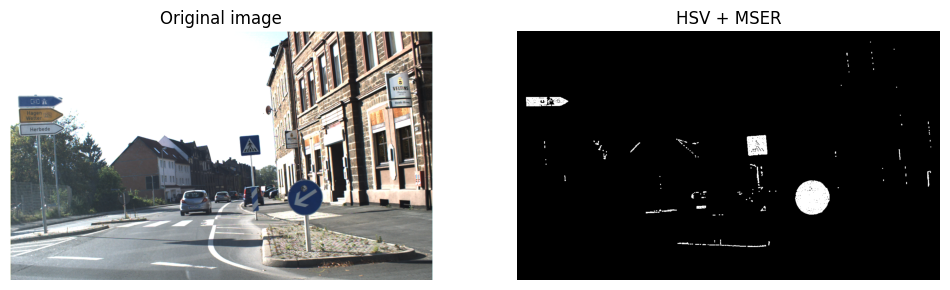

In [12]:
images_in_path = sorted(os.listdir(TRAIN_DIR), key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
images_in_path = [f for f in images_in_path if '.ppm' in f and f != 'ex.txt' and f != 'gt.txt']
image_path = os.path.join(TRAIN_DIR, images_in_path[2])
image = cv2.imread(image_path)
segmented_image = color_segmentation(image)
mser_image = mser_detection(segmented_image)
morphed_image = morphology(mser_image)

plot_images_comparison(image, morphed_image, 'Original image', 'HSV + MSER', isGray2=True)

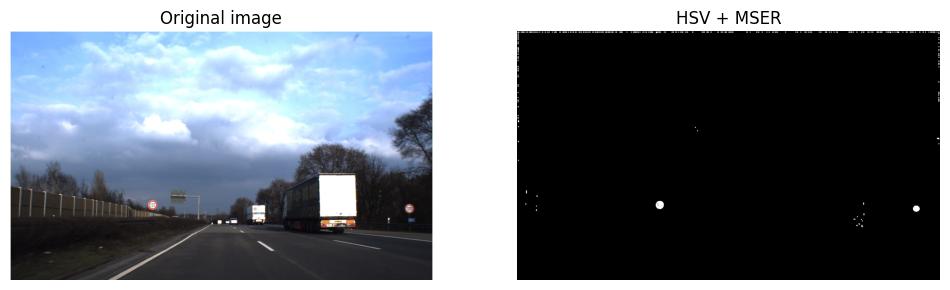

In [13]:
images_in_path = sorted(os.listdir(TEST_DIR), key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
images_in_path = [f for f in images_in_path if f != 'ReadMe.txt']
image_path = os.path.join(TEST_DIR, images_in_path[2])
image = cv2.imread(image_path)
segmented_image = color_segmentation(image)
mser_image = mser_detection(segmented_image)
morphed_image = morphology(mser_image)

plot_images_comparison(image, morphed_image, 'Original image', 'HSV + MSER', isGray2=True)

### Find Contours

In [14]:
def find_contours(image):
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

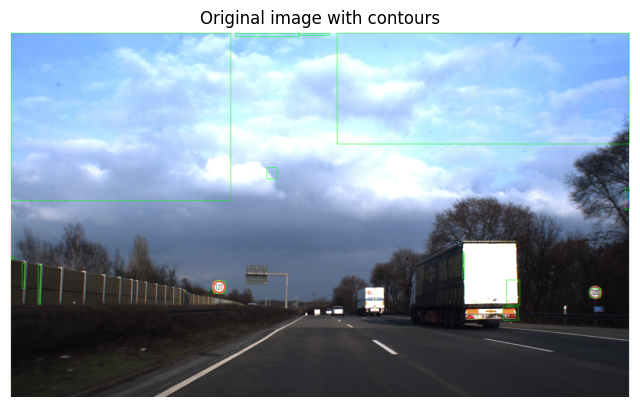

In [15]:
contours = find_contours(mser_image)
sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
image_with_contours = draw_rois(image, sorted_ctrs)

plot_image(image_with_contours, 'Original image with contours', figsize=(8, 8))

### Contour Validation

In [16]:
# Intensity thresholds for "dark" and "light"
DARK_PIXEL_THRESHOLD = 100   
LIGHT_PIXEL_THRESHOLD = 200 
DOMINANCE_THRESHOLD = 0.85   

def calculate_area_and_aspect_ratio(image):
    contours = find_contours(image)
    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < AREA_THRESHOLDS['min_area'] or area > AREA_THRESHOLDS['max_area']:
            continue
        
        # Get bounding box and aspect ratio
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if aspect_ratio < ASPECT_RATIO_THRESHOLDS['min_ratio'] or aspect_ratio > ASPECT_RATIO_THRESHOLDS['max_ratio']:
            continue
        
        # Don't count ROIs with mostly white/black pixels as valid 
        roi = image[y:y+h, x:x+w]
        total_pixels = w * h

        # Count dark and light pixels based on thresholds
        dark_pixels = np.sum(roi < DARK_PIXEL_THRESHOLD)
        light_pixels = np.sum(roi > LIGHT_PIXEL_THRESHOLD)

        # Calculate proportions
        dark_ratio = dark_pixels / total_pixels
        light_ratio = light_pixels / total_pixels

        # Check if the region is dominated by dark/light pixels
        if dark_ratio > DOMINANCE_THRESHOLD or light_ratio > DOMINANCE_THRESHOLD:
            continue  

        white_pixel_count = cv2.countNonZero(roi)  
        black_pixel_count = total_pixels - white_pixel_count

        if white_pixel_count / total_pixels > DOMINANCE_THRESHOLD or black_pixel_count / total_pixels > DOMINANCE_THRESHOLD:
            continue

        valid_contours.append(contour)
    
    return valid_contours

### Pre-processing Image Pipeline

In [17]:
def preprocess_image(image, isGray=False):
    if isGray:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        segmented_image = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,13,2)
        mser_image = mser_detection(segmented_image)
        morphed_image = morphology(mser_image, kernel_size=(13,13))
        valid_contours = find_contours(morphed_image)
    else:
        segmented_image = color_segmentation(image)
        mser_image = mser_detection(segmented_image)
        morphed_image = morphology(mser_image)
        valid_contours = calculate_area_and_aspect_ratio(morphed_image)
    return valid_contours

In [18]:
def preprocess_combined(image):
    valid_contours_color = preprocess_image(image)

    valid_contours_gray = preprocess_image(image, isGray=True)

    unique_contours = [] 
    added_rects = set()  

    def get_bounding_rect_tuple(contour):
        x, y, w, h = cv2.boundingRect(contour)
        return (x, y, w, h)
    
    def does_overlap_or_contain(rect1, rect2):
        x1, y1, w1, h1 = rect1
        x2, y2, w2, h2 = rect2

        # Check if one rectangle fully contains the other
        if (x1 <= x2 and y1 <= y2 and x1 + w1 >= x2 + w2 and y1 + h1 >= y2 + h2) or \
           (x2 <= x1 and y2 <= y1 and x2 + w2 >= x1 + w1 and y2 + h2 >= y1 + h1):
            return True

        # Check if rectangles overlap
        if not (x1 > x2 + w2 or x2 > x1 + w1 or y1 > y2 + h2 or y2 > y1 + h1):
            return True

        return False
    
    # Add color-based contours
    for contour in valid_contours_color:
        rect = get_bounding_rect_tuple(contour)
        unique_contours.append(contour)
        added_rects.add(rect)
    
    # Add grayscale-based contours
    for contour in valid_contours_gray:
        rect = get_bounding_rect_tuple(contour)
        if all(not does_overlap_or_contain(rect, added_rect) for added_rect in added_rects):
            unique_contours.append(contour)
            added_rects.add(rect)

    # print(f'Combined {len(unique_contours)} unique contours')
    return unique_contours

## Binary Classification (SVM Model)

## Note: Use this commented block of code to generate a binary classification dataset (using data from the train set and randomly choosing 3 negative samples per positive sample)

In [19]:
# # Function to generate random negative samples
# def get_random_negative_sample(image, positive_box, target_size=(64, 64)):
#     h, w = image.shape[:2]
#     # Ensure the negative sample doesn't overlap with the positive bounding box
#     while True:
#         # Randomly select top-left corner of the negative sample
#         left = random.randint(0, w - target_size[0])
#         top = random.randint(0, h - target_size[1])
        
#         # Define bottom-right corner based on the target size
#         right = left + target_size[0]
#         bottom = top + target_size[1]
        
#         # Check if the random box overlaps with the positive box
#         if not (left < positive_box[2] and right > positive_box[0] and top < positive_box[3] and bottom > positive_box[1]):
#             # No overlap, extract the negative ROI
#             roi = image[top:bottom, left:right]
#             return roi
        
# # Collect features for positive and negative samples
# positive_features = []
# negative_features = []

# ground_truth = os.path.join(TRAIN_DIR, 'gt.txt')
# # Read and process the ground truth file
# with open(ground_truth, 'r') as f:
#     for line in f:
#         # Parse the line
#         parts = line.strip().split(';')
#         image_name = parts[0]  # E.g., "00000.ppm"
#         left_col, top_row, right_col, bottom_row = map(int, parts[1:5])
#         class_id = int(parts[5])  # Traffic sign class
        
#         # Load the image
#         image_path = os.path.join(TRAIN_DIR, image_name)
#         image = cv2.imread(image_path)
        
#         if image is None:
#             print(f"Warning: Image {image_name} not found!")
#             continue
        
#         # Extract the positive sample ROI
#         positive_box = (left_col, top_row, right_col, bottom_row)
#         roi = image[top_row:bottom_row, left_col:right_col]
        
#         # Compute HOG features for positive sample
#         hog_features, hoi_image = extract_hog_features(roi)

#         # Store positive sample features and label
#         positive_features.append(hog_features)

#         # For each positive sample, generate 3 random negative samples
#         for _ in range(3):  # 3 negative samples per positive sample
#             negative_roi = get_random_negative_sample(image, positive_box)
#             negative_hog_features, _ = extract_hog_features(negative_roi)
            
#             # Store negative sample features and label
#             negative_features.append(negative_hog_features)

# positive_labels = np.ones(len(positive_features))
# negative_labels = -1 * np.ones(len(negative_features))

# # Convert to numpy arrays
# positive_features = np.array(positive_features)
# negative_features = np.array(negative_features)

# # Combine positive and negative samples
# all_features = np.concatenate((positive_features, negative_features), axis=0)
# all_labels = np.concatenate((positive_labels, negative_labels), axis=0)

# print(f"Extracted {len(positive_features)} positive samples and {len(negative_features)} negative samples.")

# output_file = 'features_labels.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump({'features': all_features, 'labels': all_labels}, f)

In [20]:
output_file = 'features_labels.pkl'
with open(output_file, 'rb') as f:
    data = pickle.load(f)

loaded_features = data['features']
loaded_labels = data['labels']

print(f"Loaded {loaded_features.shape[0]} samples with {loaded_labels.shape[0]} labels.")

Loaded 3408 samples with 3408 labels.


In [21]:
# Train SVM
clf_binary = SVC(kernel='linear', C=1)
clf_binary.fit(loaded_features, loaded_labels)

SVC(C=1, kernel='linear')

## Save SVM Model for Sign Detection Model (Binary Classification)

In [22]:
# with open('svm_binary_model.pkl', 'wb') as file:
#     pickle.dump(clf_binary, file)

In [23]:
from sklearn.cluster import KMeans
from collections import namedtuple

# Define the radii range for circle detection
RadiiRange = namedtuple('RadiiRange', ['start', 'stop'])

def traffic_light_detection(roi):
    # Assuming roi is the region of interest containing a traffic light
    top_left = None
    bottom_right = None
    active_light = None

    # Convert roi to HSV (for better color separation)
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define color ranges for red, yellow, and green in HSV
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    
    lower_green = np.array([40, 100, 100])
    upper_green = np.array([80, 255, 255])
    
    # Mask for each color
    red_mask = cv2.inRange(hsv_roi, lower_red, upper_red)
    yellow_mask = cv2.inRange(hsv_roi, lower_yellow, upper_yellow)
    green_mask = cv2.inRange(hsv_roi, lower_green, upper_green)
    
    # Count non-zero pixels for each color
    red_count = cv2.countNonZero(red_mask)
    yellow_count = cv2.countNonZero(yellow_mask)
    green_count = cv2.countNonZero(green_mask)
    
    # Create a dictionary to store counts of each color
    color_counts = {
        'red': red_count,
        'yellow': yellow_count,
        'green': green_count
    }

    # Identify the active light (the one with the most non-zero pixels)
    active_light = max(color_counts, key=color_counts.get)

    # If any light has non-zero pixels, we can get the bounding box
    if active_light == 'red' and red_count > 0:
        active_mask = red_mask
    elif active_light == 'yellow' and yellow_count > 0:
        active_mask = yellow_mask
    elif active_light == 'green' and green_count > 0:
        active_mask = green_mask
    else:
        active_mask = None
    
    # Find the bounding box of the active light (top-left and bottom-right)
    if active_mask is not None:
        # Find the contours of the active mask
        contours, _ = cv2.findContours(active_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # If there are contours, get the bounding box of the largest one
        if contours:
            # Get the bounding box of the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            # Define the top-left and bottom-right coordinates
            top_left = (x, y)
            bottom_right = (x + w, y + h)

    return (top_left, bottom_right), active_light

In [24]:
def Traffic_Sign_Recognition(svm_model, svm_binary_model, image_files):
    roi_preds = [] 
    label_preds = []
    results = []

    for image_path in image_files:
        image = cv2.imread(image_path)

        # valid_contours = preprocess_combined(image)
        valid_contours = preprocess_image(image)
        
        processed_image = draw_rois(image, valid_contours)

        # plot_images_comparison(image, processed_image, 'Original image', 'Processed image')

        rois, _ = get_rois(image, valid_contours)

        label_pred = [] 
        hog_rois = [] 
        sign_dict = {} 

        # positions, active_lights = [], [] 
        # gray_contours = preprocess_image(image, isGray=True)
        # rois_for_traffic, rois_pos = get_rois(image, gray_contours)
        # for i, roi in enumerate(rois_for_traffic):
        #     cv2.imwrite('test_roi.png', roi)
        #     position, active_light = traffic_light_detection(roi)
        #     if position != (None, None):
        #         x, y, w, h = rois_pos[i]
        #         (x1_roi, y1_roi), (x2_roi, y2_roi) = position  
        #         top_left_adjusted = (x1_roi + x, y1_roi + y)  
        #         bottom_right_adjusted = (x2_roi + x, y2_roi + y)  
                
        #         # Append the adjusted position
        #         positions.append((top_left_adjusted, bottom_right_adjusted))  
        #         active_lights.append(active_light)

        # sign_dict['traffic lights'] = []
        # sign_dict['traffic lights'].append(positions)
        # sign_dict['traffic lights'].append(active_lights)

        hog_rois = [extract_hog_features(roi)[0] for roi in rois]
        hog_rois = np.array(hog_rois)

        if len(hog_rois) > 0:
            y_pred = svm_binary_model.predict(hog_rois)
            true_pred = np.where(y_pred == 1)[0]

            if len(true_pred) > 0:
                # print(true_pred)
                true_rois = [] 
                for i in true_pred:
                    x, y, w, h = cv2.boundingRect(valid_contours[i])
                    true_rois.append((x, y, x + w, y + h))
                roi_preds.append(true_rois)

                pred_hog_rois = [hog_rois[i] for i in true_pred]
                label_pred = svm_model.predict(pred_hog_rois)
                print(f'Predicted labels for {image_path}: {label_pred}')
                label_preds.append(label_pred)
                
                pred_rois = [rois[i] for i in true_pred]
                # for i, roi in enumerate(pred_rois):
                #     plot_image(roi, f'{label_pred[i]}')

                for label, roi in zip(label_pred, true_rois):
                    sign_name = LABELS.get(label, 'Unknown')
                    x, y, x2, y2 = roi
                    location = (x, y), (x2, y2)

                    if sign_name not in sign_dict:
                        sign_dict[sign_name] = [] 
                    sign_dict[sign_name].append(location)

        if len(label_pred) == 0:
            roi_preds.append([])
            label_preds.append([])
        
        results.append(sign_dict)
    
    return roi_preds, label_preds, results

In [25]:
images_in_path = sorted(os.listdir(TEST_DIR), key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
images_in_path = [f for f in images_in_path if f != 'ReadMe.txt']
test_images = [] 
for image_file in images_in_path:
    image_path = os.path.join(TEST_DIR, image_file)
    test_images.append(image_path)

roi_preds, label_preds, results_dict = Traffic_Sign_Recognition(clf, clf_binary, test_images)

Predicted labels for test/00002.ppm: [8 8]
Predicted labels for test/00003.ppm: [10]
Predicted labels for test/00004.ppm: [30]
Predicted labels for test/00005.ppm: [4 4]
Predicted labels for test/00007.ppm: [18]
Predicted labels for test/00009.ppm: [40  8  4  4]
Predicted labels for test/00010.ppm: [4]
Predicted labels for test/00011.ppm: [10  4]
Predicted labels for test/00012.ppm: [38]
Predicted labels for test/00013.ppm: [1 5]
Predicted labels for test/00015.ppm: [ 8  8 18 18]
Predicted labels for test/00016.ppm: [ 7 12]
Predicted labels for test/00019.ppm: [13]
Predicted labels for test/00020.ppm: [9]
Predicted labels for test/00021.ppm: [4]
Predicted labels for test/00022.ppm: [22]
Predicted labels for test/00023.ppm: [4]
Predicted labels for test/00024.ppm: [38]
Predicted labels for test/00025.ppm: [2]
Predicted labels for test/00026.ppm: [9 2]
Predicted labels for test/00035.ppm: [9]
Predicted labels for test/00037.ppm: [18]
Predicted labels for test/00038.ppm: [1]
Predicted lab

## Evaluations

In [26]:
from collections import defaultdict

def calculate_iou(pred_bbox, gt_bbox):
    pred_left, pred_top, pred_right, pred_bottom = pred_bbox
    gt_left, gt_top, gt_right, gt_bottom = gt_bbox

    if (pred_left >= gt_left and pred_top >= gt_top and 
        pred_right <= gt_right and pred_bottom <= gt_bottom):
        # Predicted box is completely within ground truth
        return 1.0
    elif (gt_left >= pred_left and gt_top >= pred_top and 
        gt_right <= pred_right and gt_bottom <= pred_bottom):
        # Ground truth box is completely within predicted box
        return 1.0
        # No intersection
    elif (pred_left > gt_right or gt_left > pred_right) or (pred_top > gt_bottom or gt_top > pred_bottom):
        return 0

    x_overlap = max(0, min(pred_right, gt_right) - max(pred_left, gt_left))
    y_overlap = max(0, min(pred_bottom, gt_bottom) - max(pred_top, gt_top))

    intersection_area = x_overlap * y_overlap

    pred_area = (pred_right - pred_left) * (pred_bottom - pred_top)
    gt_area = (gt_right - gt_left) * (gt_bottom - gt_top)

    union_area = pred_area + gt_area - intersection_area

    iou = intersection_area / union_area
    return iou

In [27]:
def calculate_confusion_matrix(detected_rois, ground_truth_annotations, predicted_labels, iou_threshold=0.3, num_classes=NUM_CLASSES + 1):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    gt_by_image = defaultdict(list)
    for i in range(300):  # Assuming max 300 images
        gt_by_image[i] = []

    for gt in ground_truth_annotations:
        image_name = gt[0]
        gt_by_image[image_name].append(gt)

    # Iterate over detected ROIs and predicted labels
    for image_idx, (rois, labels) in enumerate(zip(detected_rois, predicted_labels)):
        if len(gt_by_image[image_idx]) == 0:
            continue  # Skip this image if no ground truth is available

        gt_annotations = gt_by_image[image_idx]
        matched_gt = set()

        # Match each detected ROI to the best ground truth annotation
        for pred_bbox, predicted_label in zip(rois, labels):
            best_iou = 0
            best_match = None
            for gt in gt_annotations:
                if gt in matched_gt:
                    continue
                gt_bbox = (gt[1], gt[2], gt[3], gt[4])  # (left, top, right, bottom)
                iou = calculate_iou(pred_bbox, gt_bbox)

                if iou > best_iou:
                    best_iou = iou
                    best_match = gt

            # If IoU is sufficient, update confusion matrix
            if best_iou >= iou_threshold and best_match is not None:
                true_label = best_match[5]  
                if predicted_label == true_label:  # Correct prediction
                    confusion_matrix[true_label][predicted_label] += 1
                else:  # Incorrect prediction
                    confusion_matrix[true_label][predicted_label] += 1
            else:
                confusion_matrix[num_classes-1][predicted_label] += 1  

    # Calculate accuracy
    total_samples = np.sum(confusion_matrix)
    correct_predictions = np.trace(confusion_matrix)  
    accuracy = correct_predictions / total_samples if total_samples else 0 

    return confusion_matrix, accuracy

In [28]:
gt_annotations = [] 
ground_truth = os.path.join('gt.txt')
with open(ground_truth, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        parts = line.strip().split(';')
        image_name = int(parts[0][:5]) - 600
        if image_name > 0:
            class_id = int(parts[5])  
            left_col, top_row, right_col, bottom_row = map(int, parts[1:5])
            gt_annotations.append((image_name, left_col, top_row, right_col, bottom_row, class_id))
print(gt_annotations)

[(1, 82, 450, 145, 508, 7), (2, 1268, 555, 1299, 586, 8), (2, 443, 543, 474, 574, 8), (3, 361, 445, 417, 500, 10), (4, 365, 482, 437, 546, 30), (5, 167, 511, 206, 550, 4), (5, 846, 501, 881, 535, 4), (6, 853, 501, 887, 535, 42), (7, 888, 472, 950, 526, 24), (8, 948, 370, 1001, 420, 12), (9, 809, 507, 841, 539, 4), (9, 310, 512, 343, 546, 4), (10, 912, 525, 939, 553, 12), (10, 917, 553, 938, 574, 4), (11, 839, 488, 872, 521, 4), (11, 840, 520, 873, 552, 10), (12, 127, 521, 218, 612, 38), (12, 170, 374, 246, 451, 17), (13, 1132, 561, 1169, 598, 5), (13, 478, 546, 513, 581, 5), (15, 881, 530, 926, 572, 18), (15, 890, 572, 918, 600, 8), (15, 375, 531, 421, 574, 18), (15, 386, 571, 413, 600, 8), (16, 437, 558, 463, 584, 32), (16, 876, 541, 904, 569, 32), (19, 841, 415, 880, 450, 13), (20, 863, 425, 892, 454, 9), (21, 782, 443, 808, 469, 4), (22, 814, 424, 860, 465, 22), (23, 974, 374, 1034, 434, 4), (24, 387, 505, 434, 554, 38), (24, 821, 464, 845, 488, 2), (25, 1037, 377, 1102, 443, 2), (2

In [29]:
confusion_matrix, accuracy = calculate_confusion_matrix(roi_preds, gt_annotations, label_preds)
print(f"Accuracy: {accuracy*100:.4f}%")


Accuracy: 72.4409%


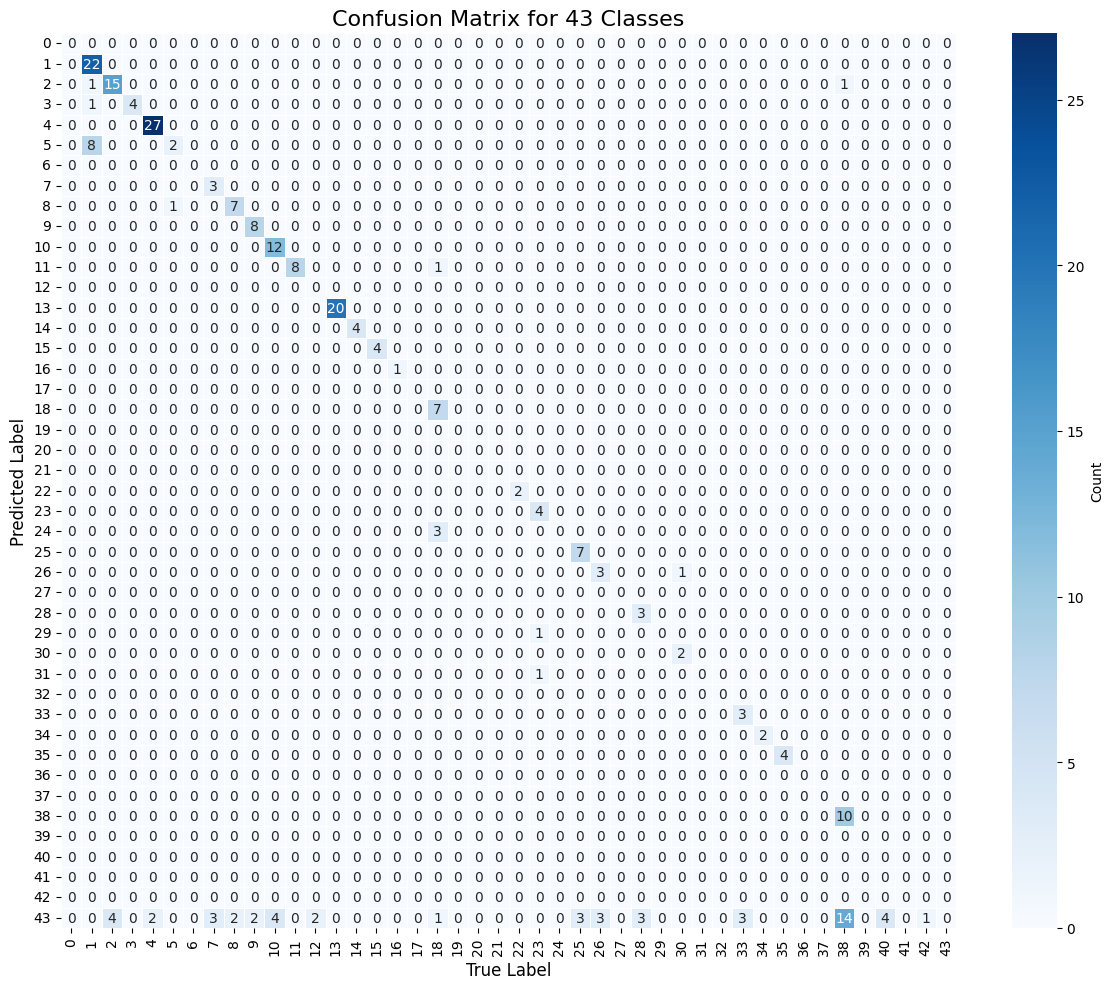

In [30]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(range(NUM_CLASSES+1)), yticklabels=list(range(NUM_CLASSES+1)),
            cbar_kws={'label': 'Count'}, annot_kws={"size": 10}, linewidths=0.5)
plt.title('Confusion Matrix for 43 Classes', fontsize=16)
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Creating Output Image with Labels

In [31]:
with open('svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('svm_binary_model.pkl', 'rb') as file_binary:
    svm_binary = pickle.load(file_binary)
    
test_image = os.path.join(TRAIN_DIR, '00306.ppm')
print(test_image)
x_pred, y_pred, results = Traffic_Sign_Recognition(svm_model, svm_binary, [test_image])

train/00306.ppm
Predicted labels for train/00306.ppm: [20 20]


In [32]:
print(results)

[{'bend right': [((357, 476), (386, 503)), ((1051, 425), (1082, 453))]}]


In [33]:
def annotate_image(image_path, annotation, output_path, showImage=False):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Cannot read from {image_path}.")
        return 
    for sign_name, locations in annotation.items():
        for location in locations:
            (x1, y1), (x2, y2) = location
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_color = (255, 255, 255) 
            thickness = 1
            line_type = cv2.LINE_AA

            (text_width, text_height), _ = cv2.getTextSize(sign_name, font, font_scale, thickness)

            text_y = y1 - text_height
            if text_y < 0:
                text_y = y1 + text_height

            cv2.rectangle(image, (x1 - 5, text_y - text_height - 5), (x1 + text_width + 5, text_y + 5), (0, 0, 0), -1)

            cv2.putText(image, sign_name, (x1, text_y), font, font_scale, font_color, thickness, lineType=line_type)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, image)       

    if showImage:
        plot_image(image, sign_name, figsize=(10, 10))

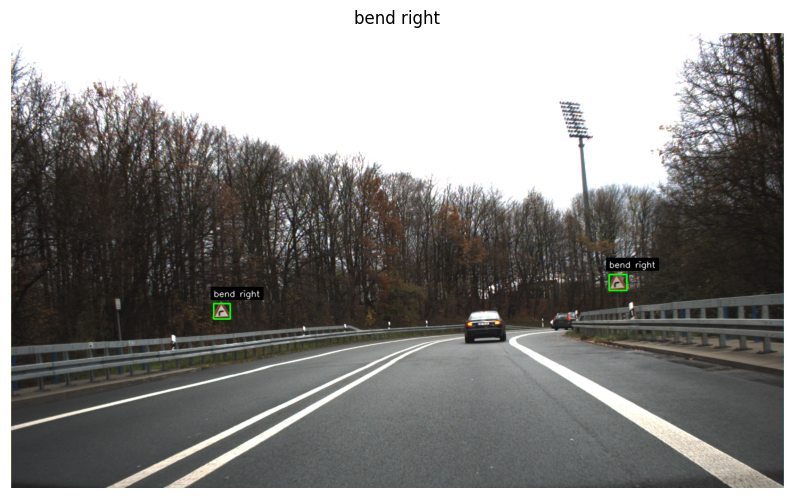

In [34]:
annotate_image(test_image, results[0], './test.png', showImage=True)

## Write the GTSDB Test set to /output folder

In [35]:
x_pred, y_pred, results = Traffic_Sign_Recognition(svm_model, svm_binary, test_images)

Predicted labels for test/00002.ppm: [8 8]
Predicted labels for test/00003.ppm: [10]
Predicted labels for test/00004.ppm: [30]
Predicted labels for test/00005.ppm: [4 4]
Predicted labels for test/00007.ppm: [18]
Predicted labels for test/00009.ppm: [40  8  4  4]
Predicted labels for test/00010.ppm: [4]
Predicted labels for test/00011.ppm: [10  4]
Predicted labels for test/00012.ppm: [38]
Predicted labels for test/00013.ppm: [1 5]
Predicted labels for test/00015.ppm: [ 8  8 18 18]
Predicted labels for test/00016.ppm: [ 7 12]
Predicted labels for test/00019.ppm: [13]
Predicted labels for test/00020.ppm: [9]
Predicted labels for test/00021.ppm: [4]
Predicted labels for test/00022.ppm: [22]
Predicted labels for test/00023.ppm: [4]
Predicted labels for test/00024.ppm: [38]
Predicted labels for test/00025.ppm: [2]
Predicted labels for test/00026.ppm: [9 2]
Predicted labels for test/00035.ppm: [9]
Predicted labels for test/00037.ppm: [18]
Predicted labels for test/00038.ppm: [1]
Predicted lab

In [36]:
output_files = [path.replace('test/', 'output/') for path in test_images] 
print(output_files)
for idx, (test_image, output_file) in enumerate(zip(test_images, output_files)):
    annotate_image(test_image, results[idx], output_file)

['output/00000.ppm', 'output/00001.ppm', 'output/00002.ppm', 'output/00003.ppm', 'output/00004.ppm', 'output/00005.ppm', 'output/00006.ppm', 'output/00007.ppm', 'output/00008.ppm', 'output/00009.ppm', 'output/00010.ppm', 'output/00011.ppm', 'output/00012.ppm', 'output/00013.ppm', 'output/00014.ppm', 'output/00015.ppm', 'output/00016.ppm', 'output/00017.ppm', 'output/00018.ppm', 'output/00019.ppm', 'output/00020.ppm', 'output/00021.ppm', 'output/00022.ppm', 'output/00023.ppm', 'output/00024.ppm', 'output/00025.ppm', 'output/00026.ppm', 'output/00027.ppm', 'output/00028.ppm', 'output/00029.ppm', 'output/00030.ppm', 'output/00031.ppm', 'output/00032.ppm', 'output/00033.ppm', 'output/00034.ppm', 'output/00035.ppm', 'output/00036.ppm', 'output/00037.ppm', 'output/00038.ppm', 'output/00039.ppm', 'output/00040.ppm', 'output/00041.ppm', 'output/00042.ppm', 'output/00043.ppm', 'output/00044.ppm', 'output/00045.ppm', 'output/00046.ppm', 'output/00047.ppm', 'output/00048.ppm', 'output/00049.ppm',